# Introduction

The purpose of this study is to learn the relationship between 

"CO2 partial pressure of the global ocean surface" 

and

"Sea surface tempreture, atmospheric pressure and CO2 concentration"

Therefore, the predictors used in this study are:

1.global sea surface tempreture (SST), as in figure

2.global sea surface atmospheric pressure (SP), as in figure

3.global average CO2 concentration, as in numeric

the predictent used in this study is:

global CO2 partial pressure of sea surface, as in figure

The time span of this study is from 1982-01-01 to 2019-12-01

# Data source and accessibility

The data used in this study are:

1.SST and SP:

the ECMWF ERA5

Data are directly dowloaded from the CDS cloud server:

Data prota: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form

2.CO2 Concentration:

Provided by NOAA Global Monitoring Laboratory

Data access: https://gml.noaa.gov/ccgg/trends/gl_data.html

3.CO2 partial pressure:

Introduction and data access are provided by National Centre for Environmental Information (NCEI), NOAA. 

Data access:https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0160558/html

Landschützer, Peter; Gruber, Nicolas; Bakker, Dorothee C. E. (2017). An observation-based global monthly gridded sea surface pCO2 product from 1982 onward and its monthly climatology (NCEI Accession 0160558). 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

from utils import * 

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

## Some visualization of the data

In [2]:
#First the CO2 partial pressure data
fco2 = xr.open_dataset('spco2_MPI-SOM_FFN_v2020.nc', drop_variables = ['date'])
fco2

<xarray.Dataset>
Dimensions:         (time: 456, lat: 180, lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2019-12-15
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables:
    dco2            (time, lat, lon) float32 ...
    atm_co2         (time, lat, lon) float32 ...
    sol             (time, lat, lon) float32 ...
    seaice          (time, lat, lon) float32 ...
    kw              (time, lat, lon) float32 ...
    spco2_raw       (time, lat, lon) float32 ...
    spco2_smoothed  (time, lat, lon) float32 ...
    fgco2_raw       (time, lat, lon) float32 ...
    fgco2_smoothed  (time, lat, lon) float32 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    lat_bnds        (lat, bnds) float32 ...
    lon_bnds        (lon, bnds) float32 ...
Attributes:
    institution:    Max Planck Institute for Meteorology, Hamburg, Germany
    institude_id:   MPI-M
    model_id:       SOM-FFN
    run_id:         SOM_FFN_v2020
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2020-04-23

In [3]:
signs = np.arange(456)
for t in signs:
    fco2.spco2_raw[t] = fco2.spco2_raw[t].fillna(0)

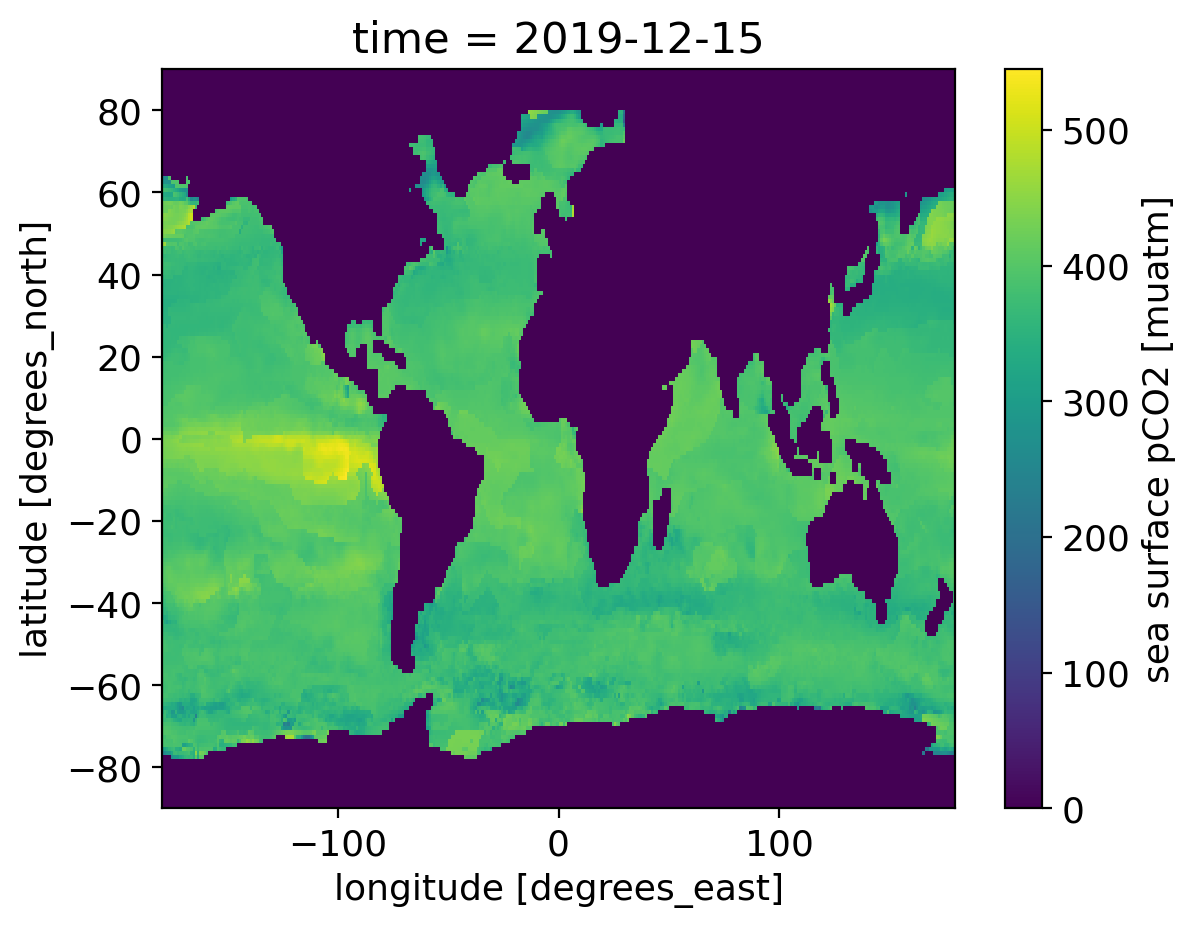

In [4]:
fco2.spco2_raw[455].plot()

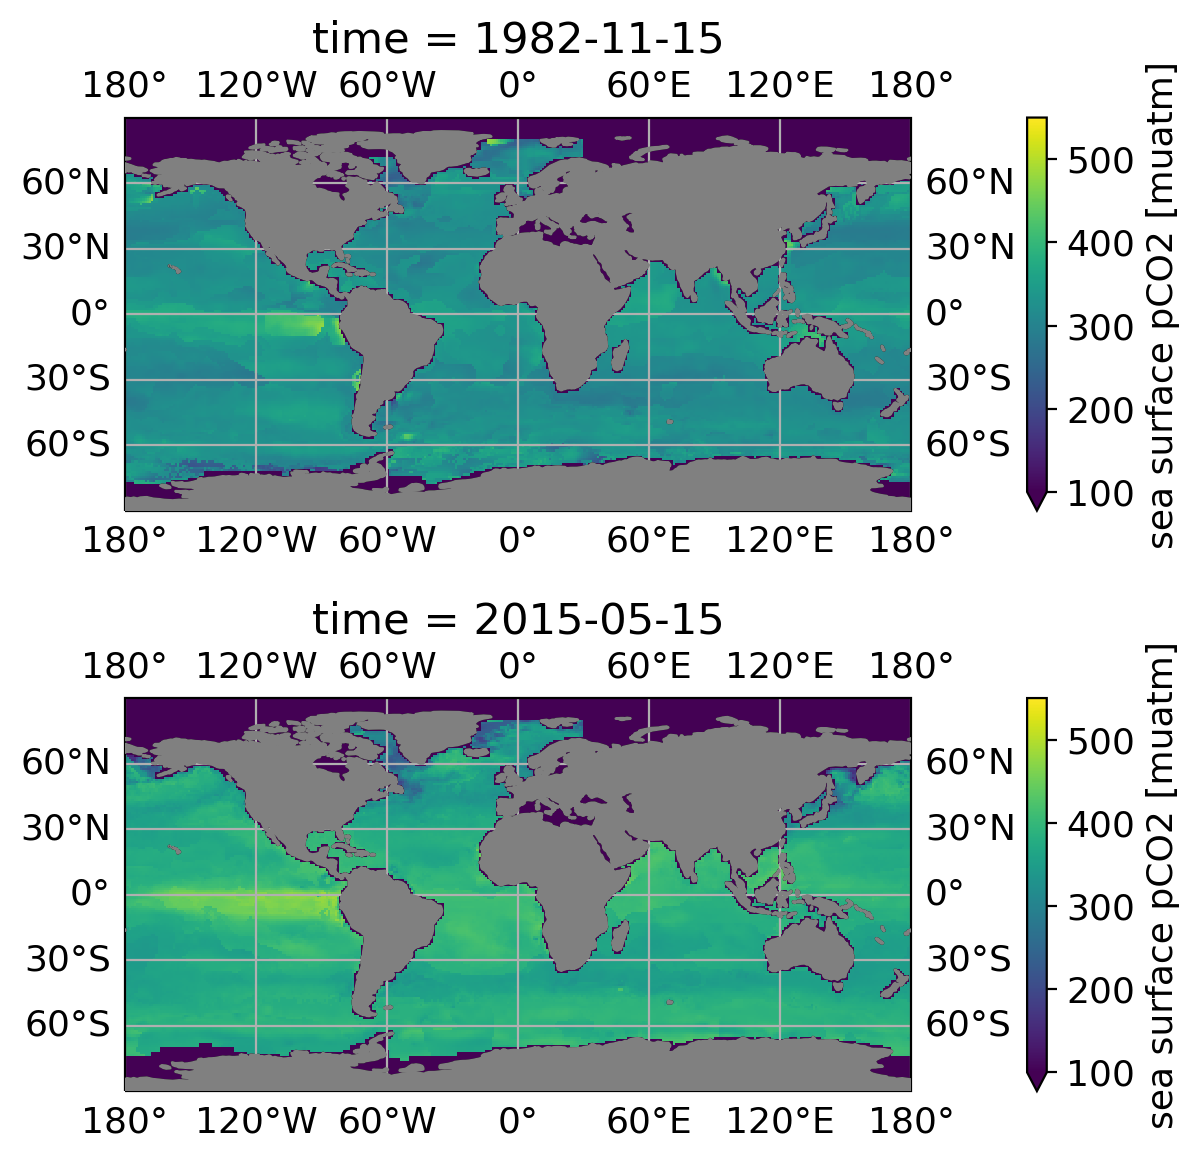

In [5]:
#Visualizaiton of the data
fig, ax = plt.subplots(nrows = 2, figsize = [12,6], sharex = True,
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}
                      )
ax1,ax2 = ax

ax1.coastlines()
ax1.gridlines(draw_labels = True)
fco2.spco2_raw[10].plot(ax = ax1, vmin=100,vmax=550,
                                    transform=ccrs.PlateCarree(central_longitude=0)
                                   )
ax1.add_feature(cfeature.LAND, 
                zorder = 10, 
                color = 'gray')

ax2.coastlines()
ax2.gridlines(draw_labels = True)
fco2.spco2_raw[400].plot(ax = ax2, vmin=100,vmax=550,
                                    transform=ccrs.PlateCarree(central_longitude=0)
                                   )
ax2.add_feature(cfeature.LAND, 
                zorder = 10, 
                color = 'gray')
plt.tight_layout()

In [6]:
#Now the data for SST and SP
envi = xr.open_dataset('download.nc')
envi

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 456)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-28 18:40:03 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
for t in signs:
    envi.sst[t] = envi.sst[t].fillna(0)

envi.sst[455].plot()

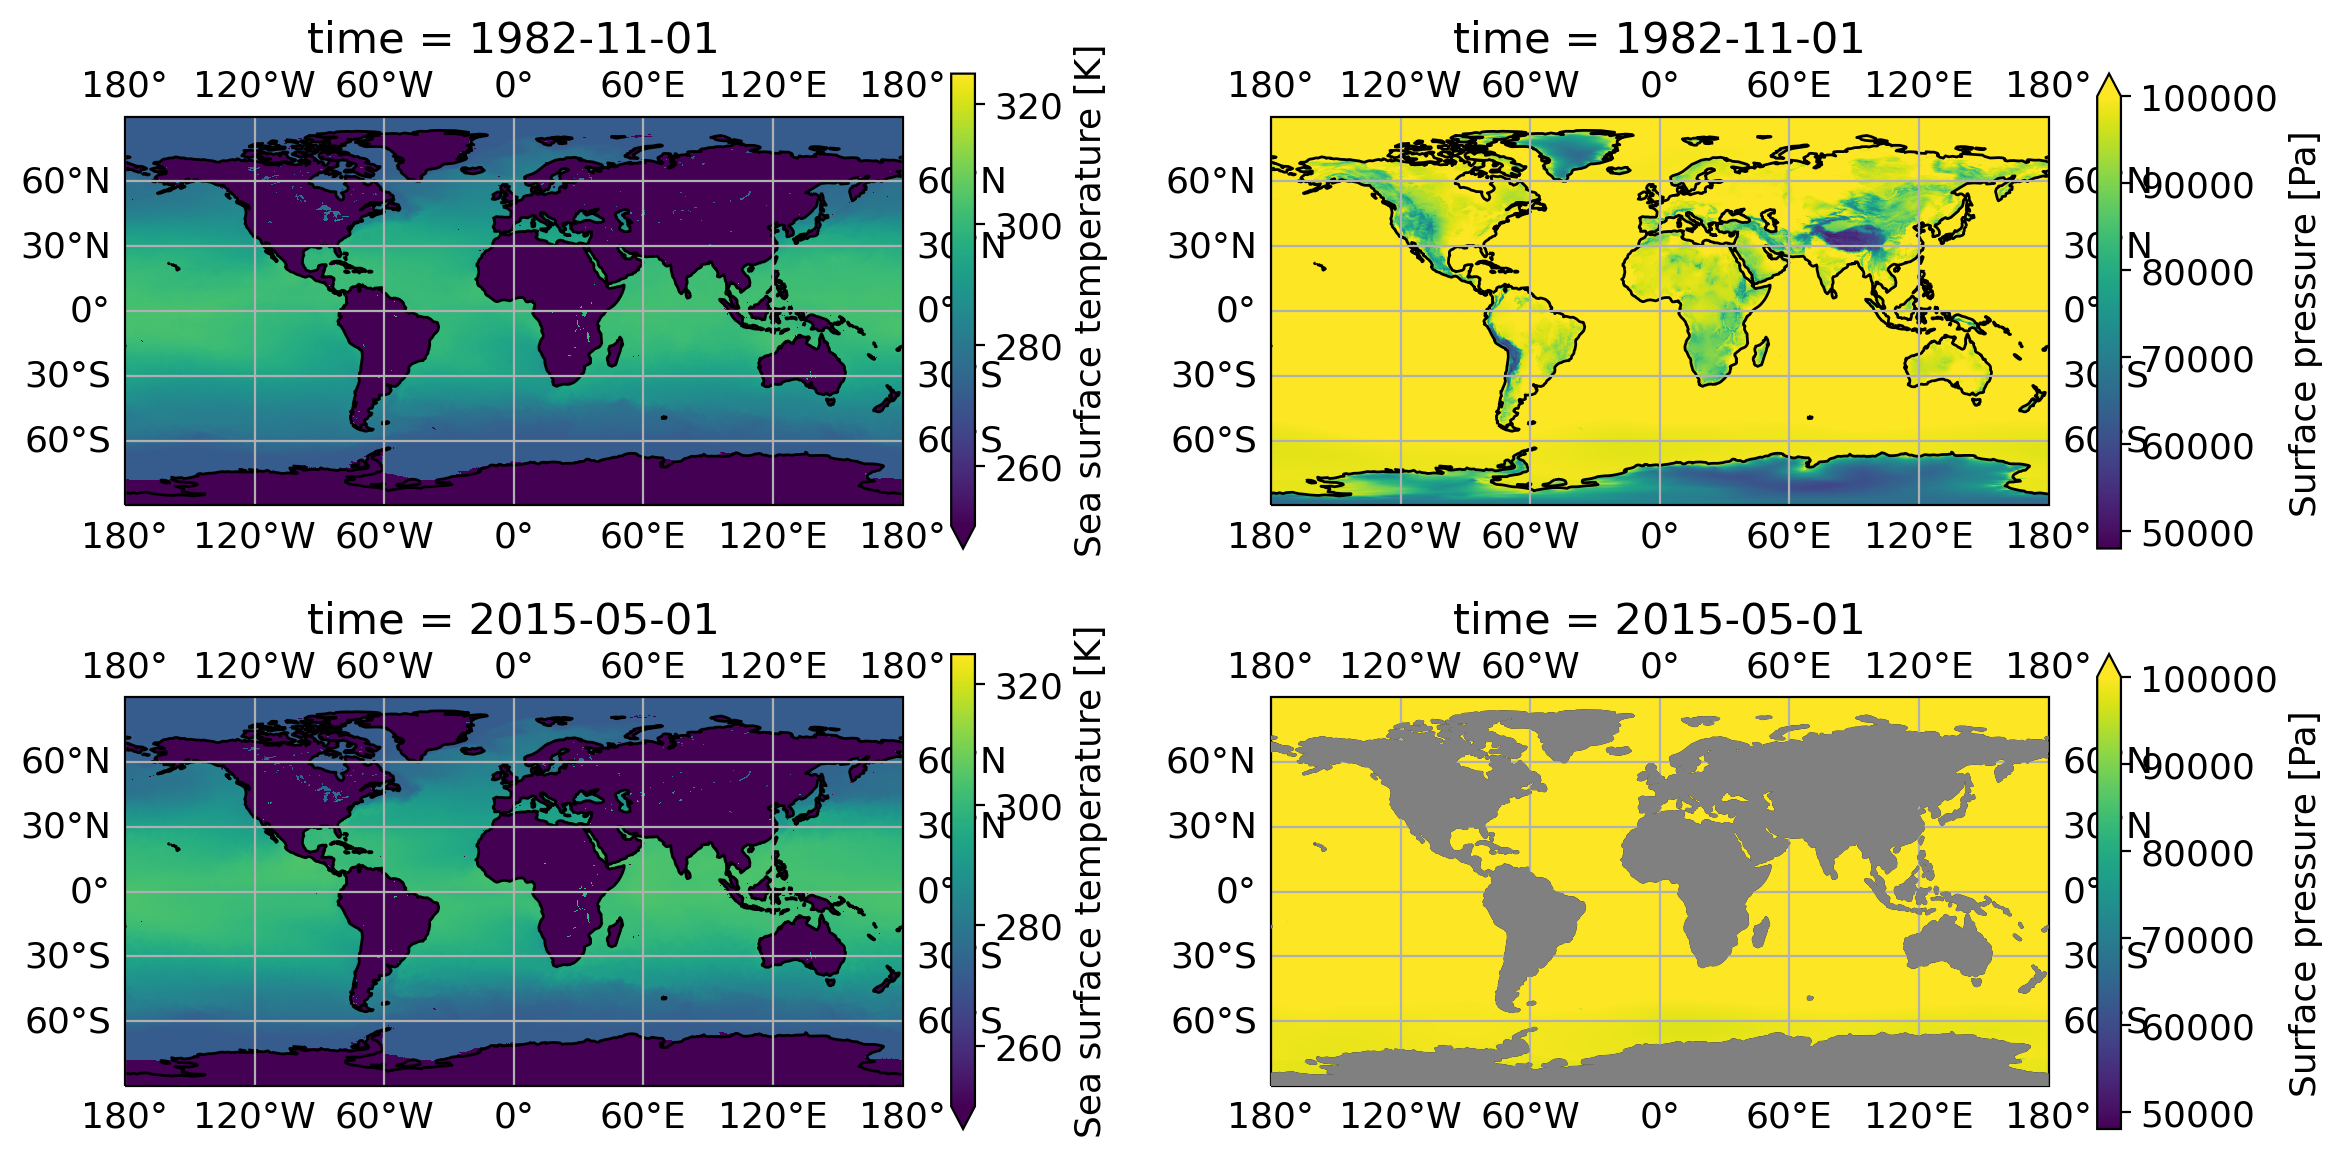

In [8]:
#Visualizaiton of the data
fig, ax = plt.subplots(nrows = 2, figsize = [12,6], ncols = 2,
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}
                      )

#The SST
ax[0,0].coastlines()
ax[0,0].gridlines(draw_labels = True)
envi.sst[10].plot(ax = ax[0,0], vmin=250,vmax=325,
                                    transform=ccrs.PlateCarree(central_longitude=0)
                                   )
#ax[0,0].add_feature(cfeature.LAND, zorder = 10, color = 'gray')

ax[1,0].coastlines()
ax[1,0].gridlines(draw_labels = True)
envi.sst[400].plot(ax = ax[1,0], vmin=250,vmax=325,
                                    transform=ccrs.PlateCarree(central_longitude=0)
                                   )
#ax[1,0].add_feature(cfeature.LAND, zorder = 10, color = 'gray')

#The SP

ax[0,1].coastlines()
ax[0,1].gridlines(draw_labels = True)
envi.sp[10].plot(ax = ax[0,1], vmin=48000,vmax=100000,
                                    transform=ccrs.PlateCarree(central_longitude=0)
                                   )
#ax[0,1].add_feature(cfeature.LAND, zorder = 10, color = 'gray')

ax[1,1].coastlines()
ax[1,1].gridlines(draw_labels = True)
envi.sp[400].plot(ax = ax[1,1], vmin=48000,vmax=100000,
                                    transform=ccrs.PlateCarree(central_longitude=0)
                                   )
ax[1,1].add_feature(cfeature.LAND, zorder = 10, color = 'gray')

plt.tight_layout()

In [9]:
CO2 = pd.read_csv('CO2.csv')
CO2["time"] = pd.to_datetime(CO2["time"])
CO2 = CO2.set_index('time')
CO2.head()

,CO2
time,
1982-01-01,341.37
1982-02-01,341.95
1982-03-01,342.23
1982-04-01,342.52
1982-05-01,342.36


In [10]:
co2_mm = CO2.to_xarray()
x = xr.merge([envi,co2_mm],compat = "equals", fill_value = co2_mm)
x = x.sel(latitude = slice(90,-89.75))
x = x.assign_coords(longitude=(x.longitude + 180) % 360 - 180)
x1 = x.sortby('longitude', ascending = True)
x1

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 720, time: 456)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    CO2        (time) float64 341.4 341.9 342.2 342.5 ... 409.4 410.9 411.8
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-28 18:40:03 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Data downsampling

In [11]:
x3 = x1.coarsen(longitude = 2, boundary = 'exact', side = 'right').mean()
x3 = x3.coarsen(latitude = 2, boundary = 'exact', side = 'right').mean()
x3

<xarray.Dataset>
Dimensions:    (time: 456, latitude: 360, longitude: 720)
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.4 -178.9 ... 178.6 179.1 179.6
  * latitude   (latitude) float32 89.88 89.38 88.88 ... -88.62 -89.12 -89.62
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
Data variables:
    sst        (time, latitude, longitude) float32 271.5 271.5 271.5 ... 0.0 0.0
    sp         (time, latitude, longitude) float32 1.019e+05 ... 6.911e+04
    CO2        (time) float64 341.4 341.9 342.2 342.5 ... 409.4 410.9 411.8
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-28 18:40:03 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

x_n = x1

ti = np.arange(0,456)
lati = np.arange(0,720)
longi = np.arange(0,1440)

for time in ti:
    for latitude in lati:
        for longitude in longi:
            if x1.sst[time][latitude][longitude].data == 0:
                x_n.sp[time][latitude][longitude] = x_n.sp[time][latitude][longitude] * 0
            continue
                
x_n

## Data Preparation

### Using randam input and normalization

In [12]:
import random
from random import sample
total = np.arange(0,456,1)
total = list(total)
x = random.sample(total,k = 342)
x = np.array(x)
x.shape

(342,)

In [13]:
for i in x:
    index = np.argwhere(total == i)
    total = np.delete(total,index)

t_v = total
t_v.shape

(114,)

In [14]:
#Traning Data
x_train = x3.isel(time = x)
y_train = fco2.isel(time = x)

#Test Data
x_test = x3.isel(time = t_v)
y_test = fco2.isel(time = t_v)

In [15]:
# Compute mean/std of each variable for the whole dataset
meanstd_inputs = {}
meanstd_inputs_y = {}
predictors     = ['CO2', 'sst', 'sp']
predictant     = ['spco2_raw']

for var in predictors:
    meanstd_inputs[var] = (x_train[var].data.mean(),x_train[var].data.std())
    
#for var in predictant:
#    meanstd_inputs_y[var] = (y_train[var].data.mean(),y_train[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = x_train[var].dims
    x_train = x_train.assign({var: (var_dims, normalize(x_train[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = x_test[var].dims
    x_test = x_test.assign({var: (var_dims, normalize(x_test[var].data, var, meanstd_inputs))})

In [16]:
x_train_np = x_train.to_array().transpose('time', 'latitude', 'longitude', 'variable').data
x_test_np  = x_test.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

y_train_np = y_train.spco2_raw.transpose('time', 'lat', 'lon').data
y_test_np = y_test.spco2_raw.transpose('time', 'lat', 'lon').data

print(x_train_np.shape,y_train_np.shape,x_test_np.shape,y_test_np.shape)

(342, 360, 720, 3) (342, 180, 360) (114, 360, 720, 3) (114, 180, 360)


### Data reshape for LSTM

In [17]:
x_train_np.shape

(342, 360, 720, 3)

In [18]:
slider = 5

xl_train  = np.array([x_train_np[i:i+slider] for i in range(0, x_train_np.shape[0]-slider+1)])
yl_train  = np.array([y_train_np[i+slider-1] for i in range(0, y_train_np.shape[0]-slider+1)])

xl_test  = np.array([x_test_np[i:i+slider] for i in range(0, x_test_np.shape[0]-slider+1)])

In [19]:
print(xl_train.shape,yl_train.shape,xl_test.shape)

(338, 5, 360, 720, 3) (338, 180, 360) (110, 5, 360, 720, 3)


## Custom Loss Function

In [20]:
from tensorflow.keras import backend as K


def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

## CNN-LSTM Model Construction

In [21]:
nf   = 20 # number of filters
ks = (3,3)  # kernel size for Covolutional layers
pool_size   = 2 # size for average pooling layers
n_lstm_unit = 25 # number of LSTM units
ac  = 'relu' # activation function
lr = 1e-3 # learning rate
minibatch_size = 32   # batch size
num_epochs     = 50   # number of total epochs

In [22]:
model = Sequential()

model.add(Input(shape=(slider, 360, 720, 3)))
model.add(TimeDistributed(Conv2D(nf, ks, 
                                     padding='same', activation=ac), input_shape=(slider, 360, 720, 3)))
model.add(TimeDistributed(AveragePooling2D(pool_size)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(n_lstm_unit, activation=ac))
model.add(Dense(180*360))
model.add(Activation('linear'))
model.add(Reshape((180, 360)))

#put LSTM into a lower dimension layer

model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
#for classification, change the loss to crosscentrophy
model.summary()

2022-12-22 14:29:44.011389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 360, 720, 20)  560       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 180, 360, 20)  0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 20)            0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 25)                4600      
                                                                 
 dense (Dense)               (None, 64800)             1684800   
                                                        

## Train Model

In [23]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0, patience=4, verbose=1, mode='min')

history = model.fit(xl_train, yl_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
9/9 [==============================] - 187s 20s/step - loss: 358.6937 - val_loss: 359.8062
Epoch 2/50
9/9 [==============================] - 134s 15s/step - loss: 358.6599 - val_loss: 359.7728
Epoch 3/50
9/9 [==============================] - 125s 14s/step - loss: 358.6288 - val_loss: 359.6820
Epoch 4/50
9/9 [==============================] - 120s 13s/step - loss: 358.4686 - val_loss: 359.3371
Epoch 5/50
9/9 [==============================] - 121s 13s/step - loss: 357.7304 - val_loss: 357.2664
Epoch 6/50
9/9 [==============================] - 118s 13s/step - loss: 353.0126 - val_loss: 345.7134
Epoch 7/50
9/9 [==============================] - 117s 13s/step - loss: 332.0251 - val_loss: 304.0247
Epoch 8/50
9/9 [==============================] - 122s 14s/step - loss: 266.0057 - val_loss: 184.0216
Epoch 9/50
9/9 [==============================] - 124s 14s/step - loss: 114.7266 - val_loss: 108.9796
Epoch 10/50
9/9 [==============================] - 121s 14s/step - loss: 72.0409 -

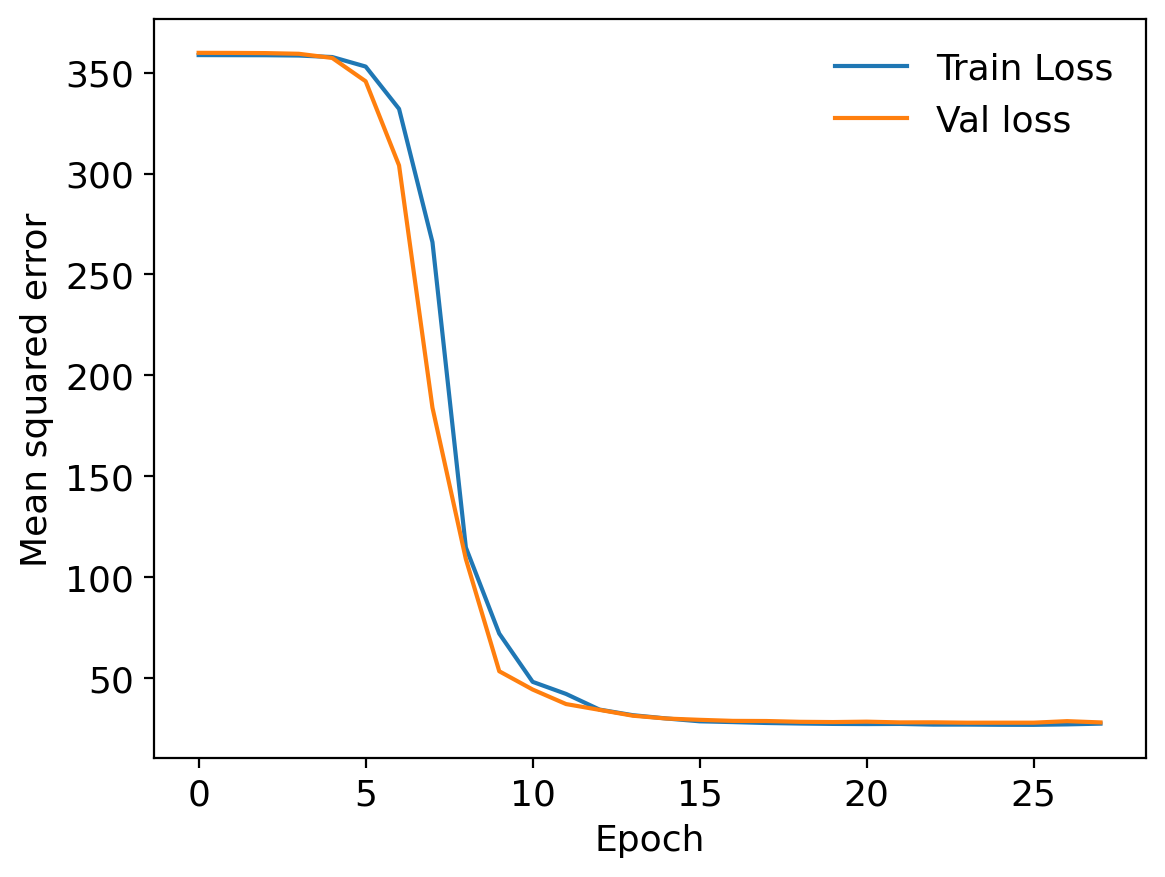

In [41]:
plot_history(history)

In [31]:
y_test_pre = model.predict(xl_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 180, 360)
y_test_pre = xr.Dataset(coords={'time': y_test.time.values[slider-1:], 
                               'latitude': y_test.lat.values, 
                               'longitude': y_test.lon.values},
                       data_vars=dict(pre=(['time', 'latitude', 'longitude'], y_test_pre)))

4/4 [==============================] - 10s 2s/step


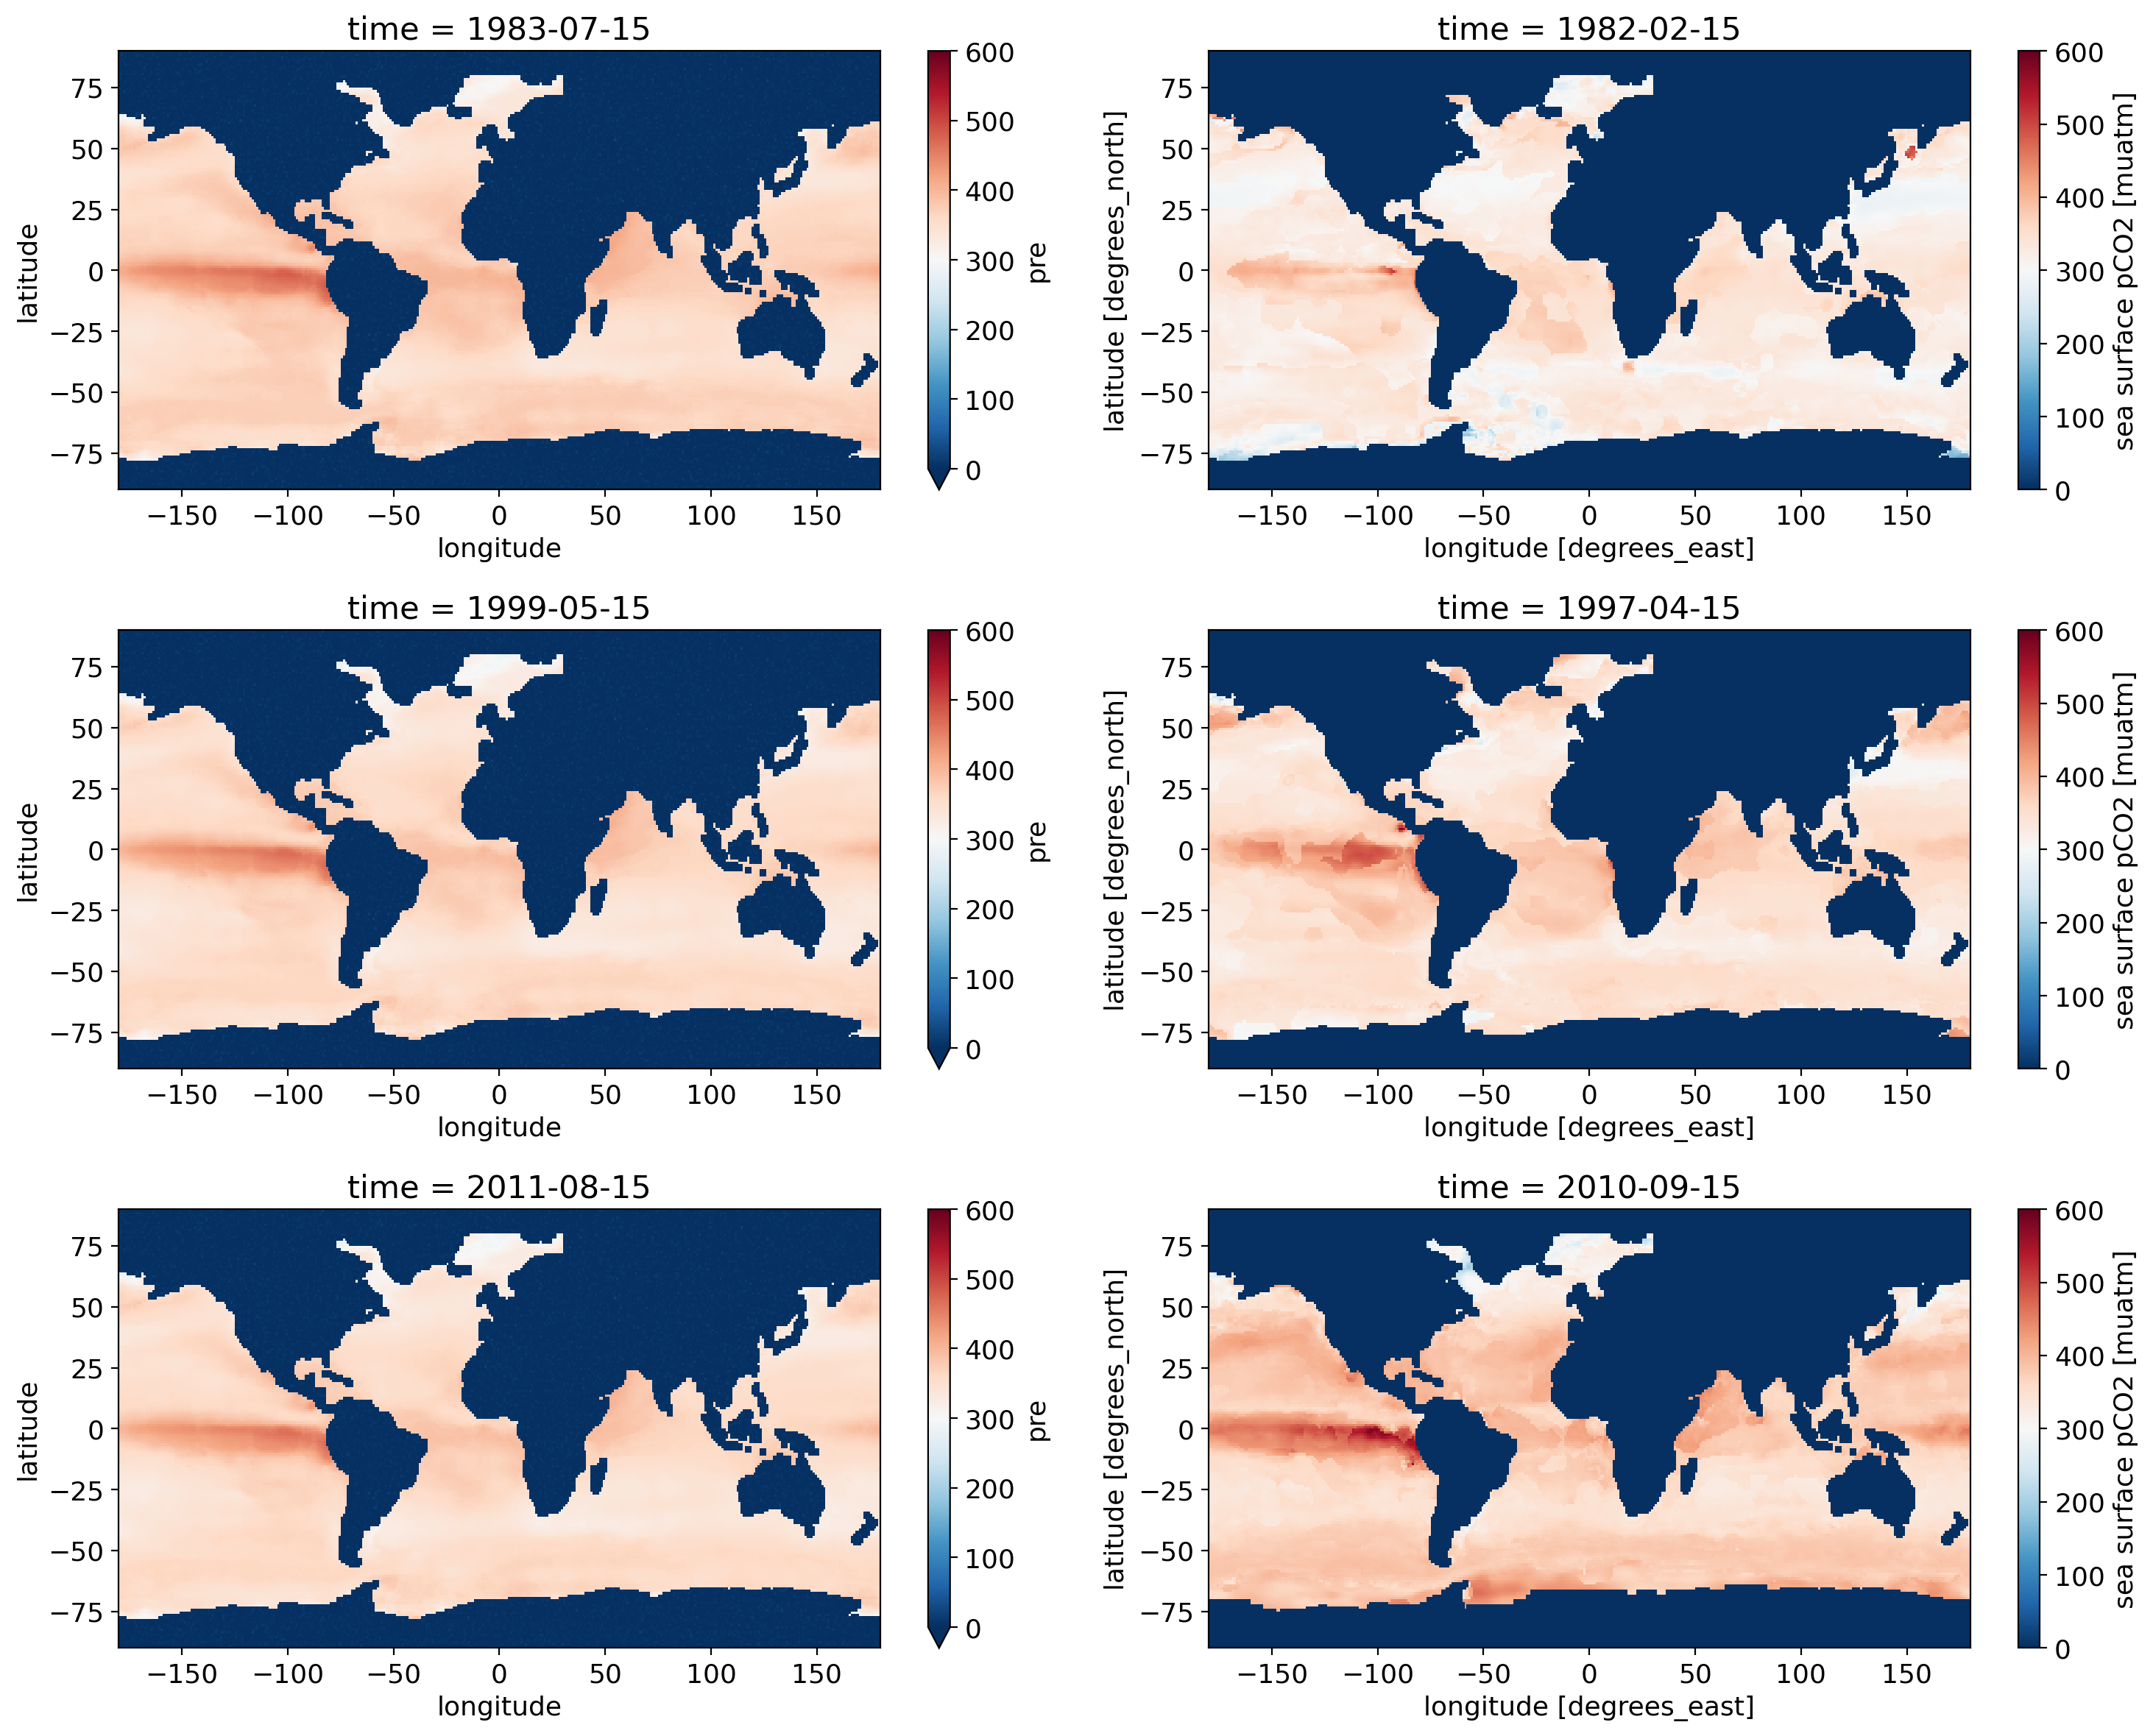

In [42]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

t = [1, 50, 90]
vmin, vmax    = 0, 600
cmap = 'RdBu_r'
y_test_pre.pre[t[0]].plot(ax=axes[0,0], 
                                   vmin=vmin, vmax=vmax,
                                   cmap=cmap)
y_test.spco2_raw[t[0]].plot(ax=axes[0,1], 
                                  vmin=vmin, vmax=vmax,
                                 cmap=cmap)

y_test_pre.pre[t[1]].plot(ax=axes[1,0], 
                                   vmin=vmin, vmax=vmax,
                                   cmap=cmap)
y_test.spco2_raw[t[1]].plot(ax=axes[1,1], 
                                  vmin=vmin, vmax=vmax,
                                  cmap=cmap)

y_test_pre.pre[t[2]].plot(ax=axes[2,0], 
                                   vmin=vmin, vmax=vmax,
                                   cmap=cmap)
y_test.spco2_raw[t[2]].plot(ax=axes[2,1], 
                                  vmin=vmin, vmax=vmax,
                                 cmap=cmap)



plt.tight_layout()

In [46]:
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)
model.save(os.path.join(model_path,'CNN-LSTM_pCO2.h5'))

## Hyperparameter tuning

In [44]:
from sklearn.metrics import r2_score

r = r2_score(y_test.spco2_raw[t[1]], y_test_pre.pre[t[1]])
r

0.9912240649865489

In [21]:
nf   = 25 # number of filters
ks = (2,2)  # kernel size for Covolutional layers
pool_size   = 2 # size for average pooling layers
n_lstm_unit = 25 # number of LSTM units
ac  = 'relu' # activation function
lr = 1e-3 # learning rate
minibatch_size = 32   # batch size
num_epochs     = 50   # number of total epochs

In [22]:
model_1 = Sequential()

model_1.add(Input(shape=(slider, 360, 720, 3)))
model_1.add(TimeDistributed(Conv2D(nf, ks, 
                                     padding='same', activation=ac), input_shape=(slider, 360, 720, 3)))
model_1.add(TimeDistributed(AveragePooling2D(pool_size)))
model_1.add(TimeDistributed(GlobalAveragePooling2D()))
model_1.add(LSTM(n_lstm_unit, activation=ac))
model_1.add(Dense(180*360))
model_1.add(Activation('linear'))
model_1.add(Reshape((180, 360)))

#put LSTM into a lower dimension layer

model_1.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
#for classification, change the loss to crosscentrophy
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 360, 720, 25)  325       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 180, 360, 25)  0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 25)            0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 64800)             1684800   
                                                        

2022-12-23 05:55:58.380718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0, patience=4, verbose=1, mode='min')

history = model_1.fit(xl_train, yl_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
9/9 [==============================] - 249s 26s/step - loss: 358.4974 - val_loss: 361.1107
Epoch 2/50
9/9 [==============================] - 233s 25s/step - loss: 358.4713 - val_loss: 361.0750
Epoch 3/50
9/9 [==============================] - 243s 27s/step - loss: 358.4194 - val_loss: 360.9844
Epoch 4/50
9/9 [==============================] - 231s 25s/step - loss: 358.2594 - val_loss: 360.6875
Epoch 5/50
9/9 [==============================] - 237s 26s/step - loss: 357.6284 - val_loss: 359.3492
Epoch 6/50
9/9 [==============================] - 240s 25s/step - loss: 354.5215 - val_loss: 352.6454
Epoch 7/50
9/9 [==============================] - 247s 28s/step - loss: 340.8731 - val_loss: 326.3725
Epoch 8/50
9/9 [==============================] - 238s 26s/step - loss: 295.1285 - val_loss: 249.0900
Epoch 9/50
9/9 [==============================] - 1495s 183s/step - loss: 176.5121 - val_loss: 84.0281
Epoch 10/50
9/9 [==============================] - 238s 26s/step - loss: 89.5892 

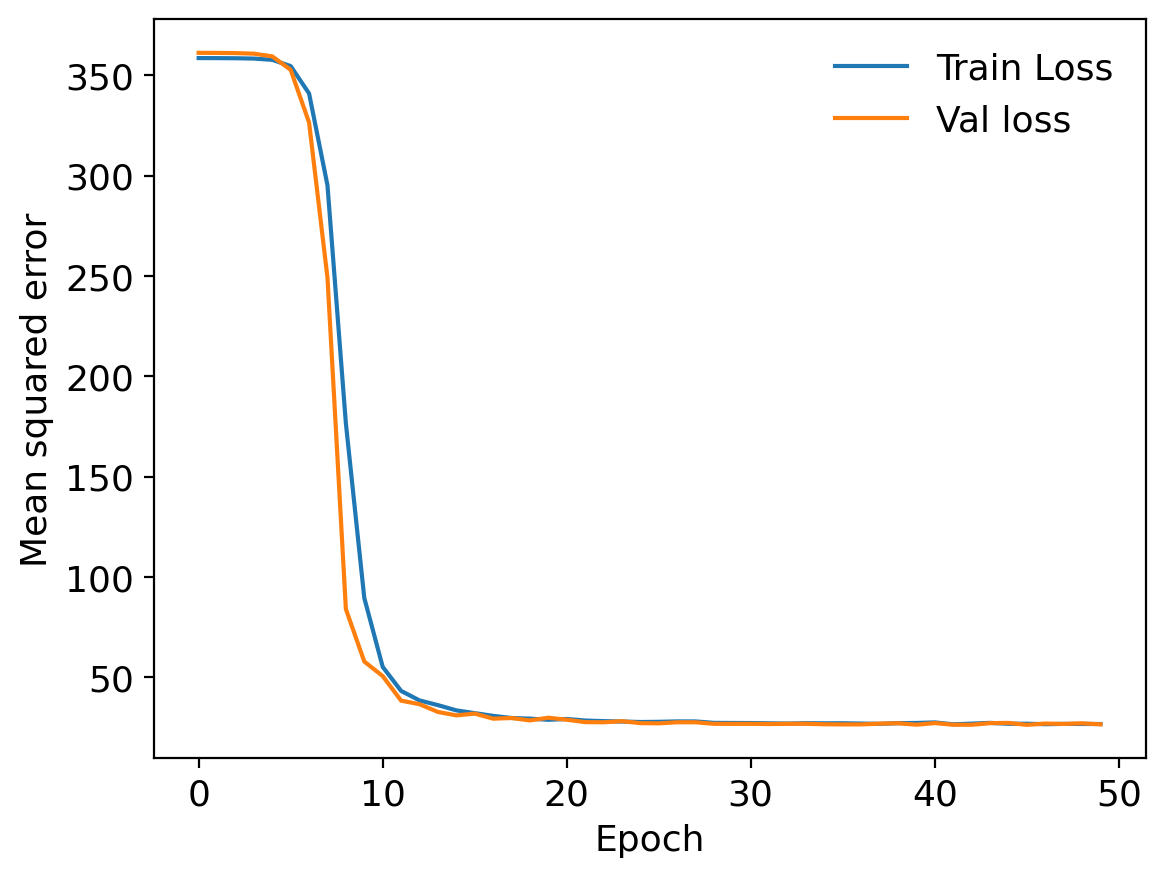

In [24]:
plot_history(history)

In [25]:
y_test_pre_1 = model_1.predict(xl_test)
y_test_pre_1 = y_test_pre_1.reshape(y_test_pre_1.shape[0], 180, 360)
y_test_pre_1 = xr.Dataset(coords={'time': y_test.time.values[slider-1:], 
                               'latitude': y_test.lat.values, 
                               'longitude': y_test.lon.values},
                       data_vars=dict(pre=(['time', 'latitude', 'longitude'], y_test_pre_1)))

4/4 [==============================] - 15s 3s/step


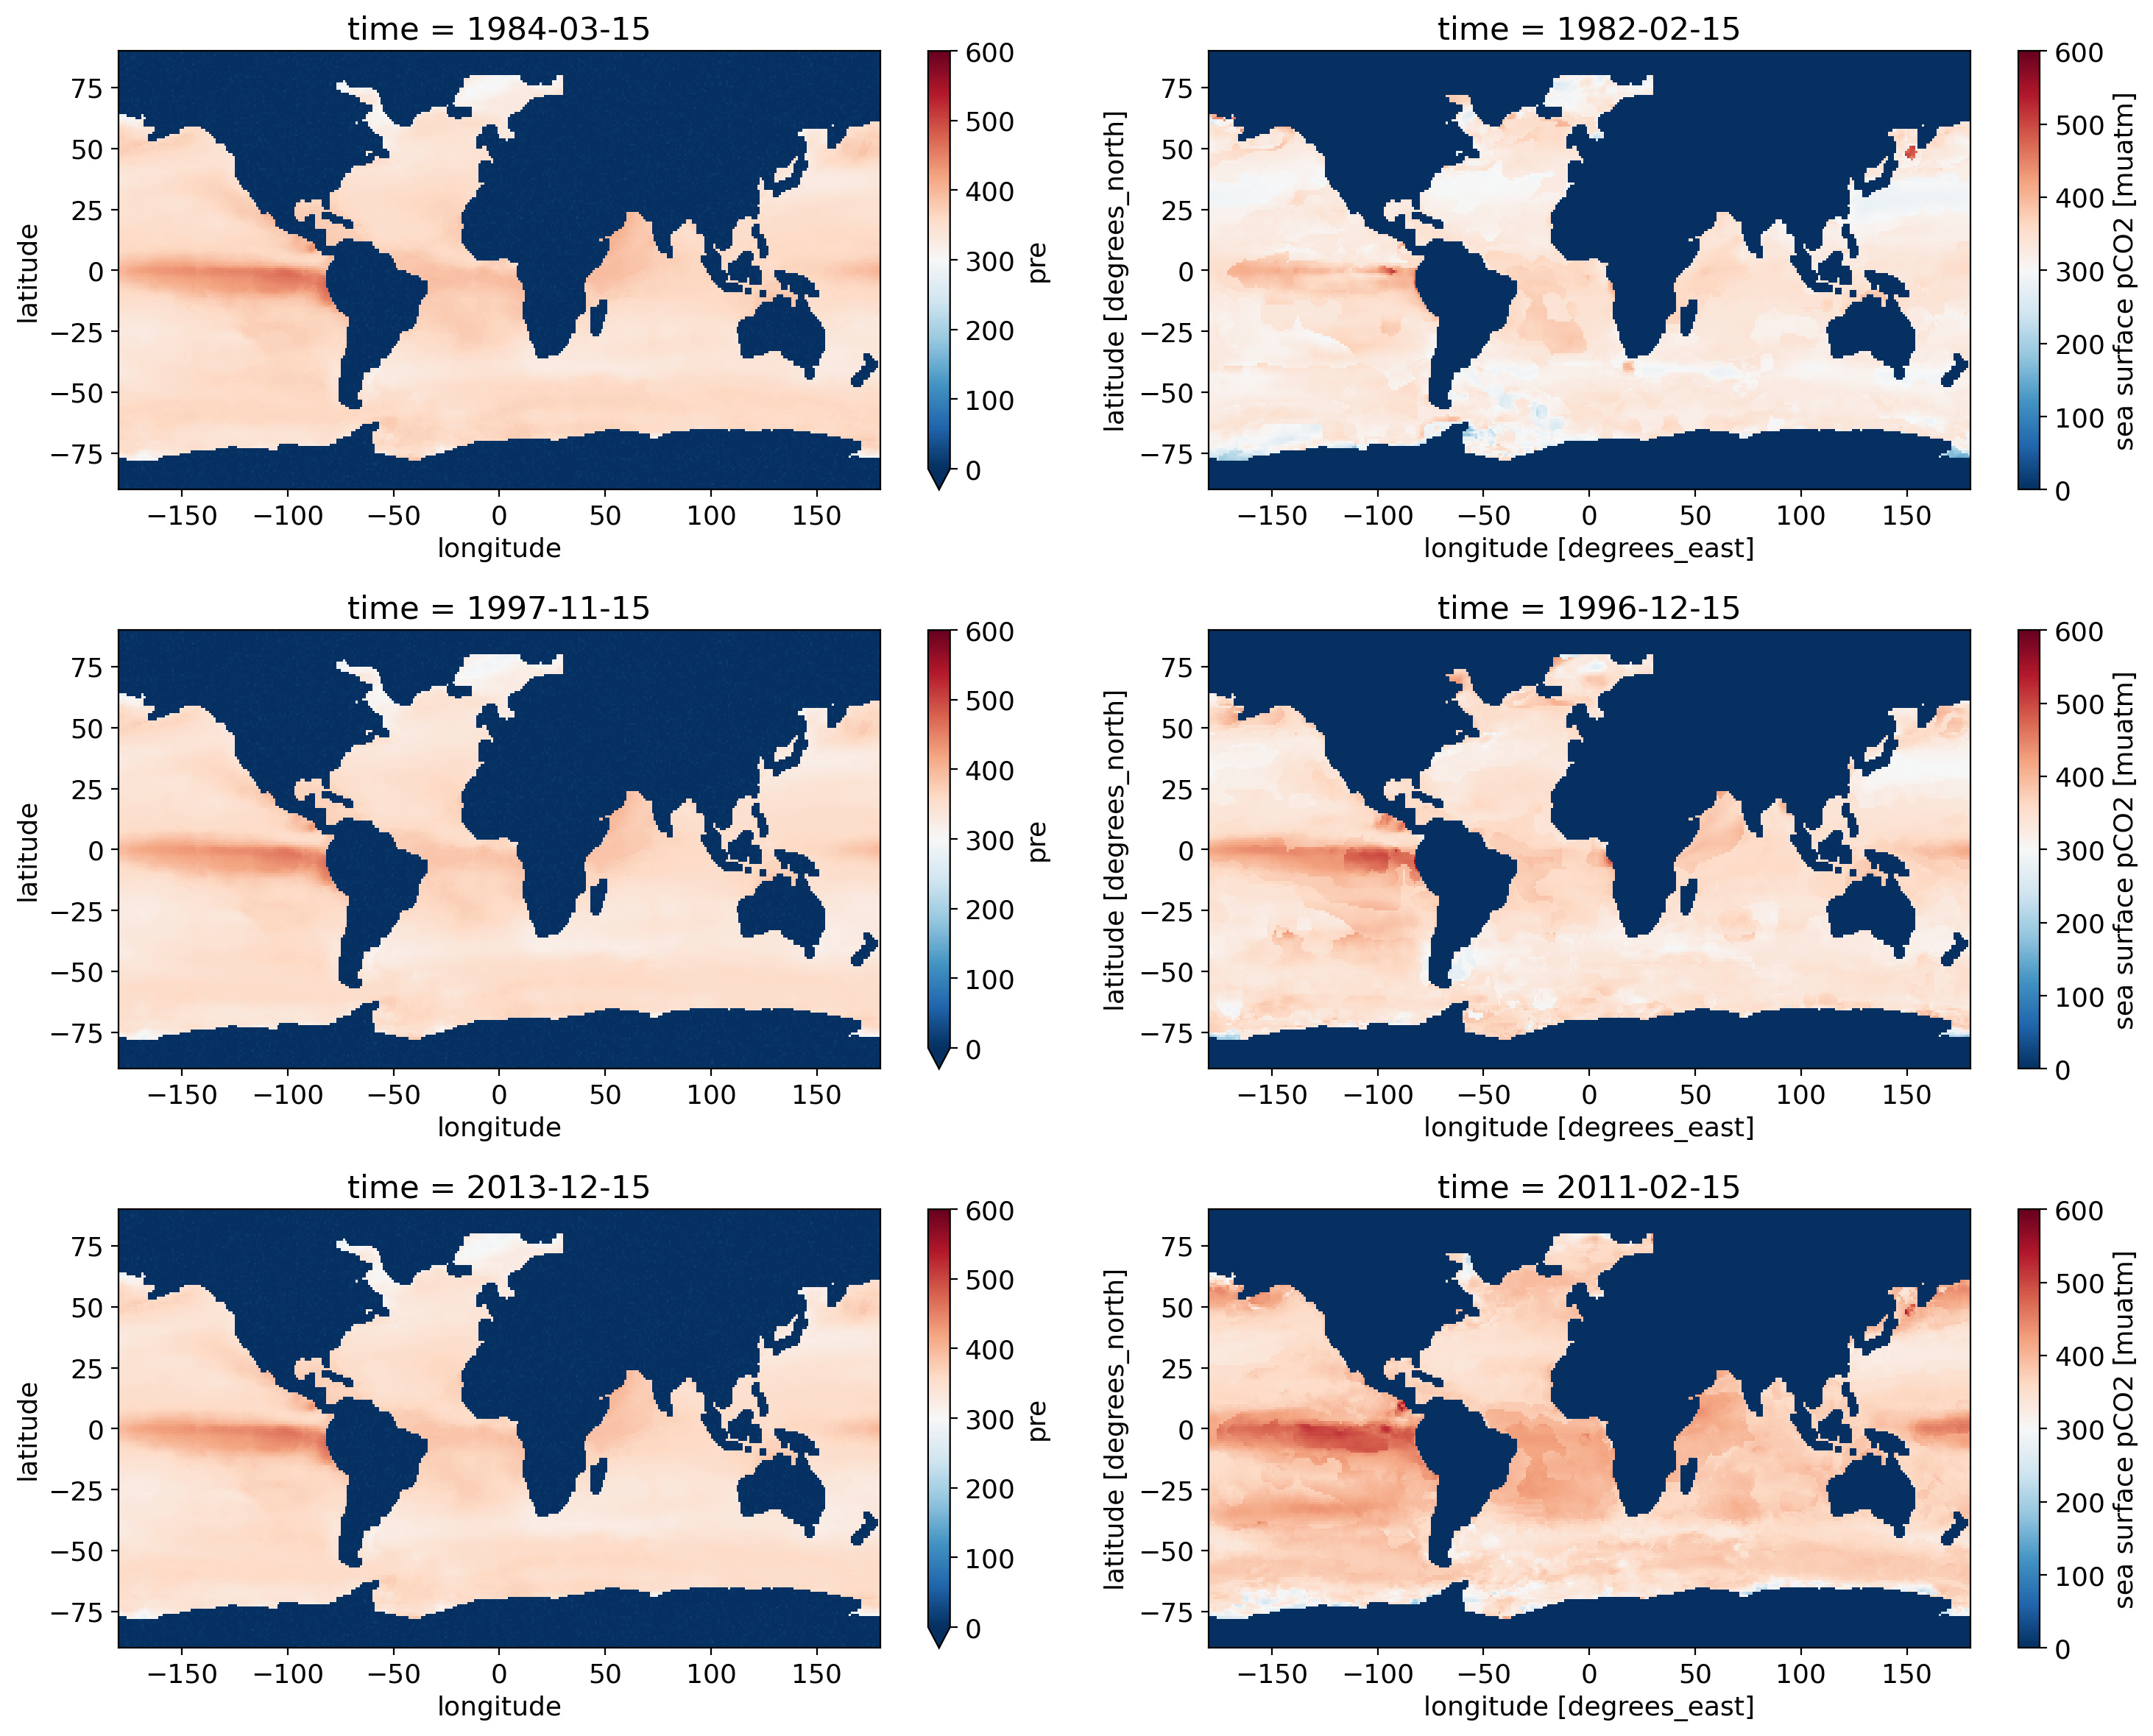

In [27]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

t = [1, 50, 90]
vmin, vmax    = 0, 600
cmap = 'RdBu_r'
y_test_pre_1.pre[t[0]].plot(ax=axes[0,0], 
                                   vmin=vmin, vmax=vmax,
                                   cmap=cmap)
y_test.spco2_raw[t[0]].plot(ax=axes[0,1], 
                                  vmin=vmin, vmax=vmax,
                                 cmap=cmap)

y_test_pre_1.pre[t[1]].plot(ax=axes[1,0], 
                                   vmin=vmin, vmax=vmax,
                                   cmap=cmap)
y_test.spco2_raw[t[1]].plot(ax=axes[1,1], 
                                  vmin=vmin, vmax=vmax,
                                  cmap=cmap)

y_test_pre_1.pre[t[2]].plot(ax=axes[2,0], 
                                   vmin=vmin, vmax=vmax,
                                   cmap=cmap)
y_test.spco2_raw[t[2]].plot(ax=axes[2,1], 
                                  vmin=vmin, vmax=vmax,
                                 cmap=cmap)



plt.tight_layout()